## **SKENARIO 1: Klasifikasi KNN - Feature Selection**

## **IMPORT LIBRARY**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
import time

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

## **DATA LOADING**

In [2]:
# Load dan read data
url_train = "https://drive.google.com/uc?export=download&id=1mwBc1Xbdp5vezgcQLi-BWcsaVNxiqblv"
url_test = "https://drive.google.com/uc?export=download&id=1nSQr83pGwZQ-ShLgrDWH0AoPEi3E5FgF"
url_label = "https://drive.google.com/uc?export=download&id=169-NXQYAKyntsfhcEjzWc0oNB4dD4DkQ"

df_train = pd.read_csv(url_train)
df_test = pd.read_csv(url_test)
df_label = pd.read_csv(url_label)

In [3]:
# Menggabungkan fitur train dan label 
df = pd.concat([df_train, df_label], axis=1)
print(f"Dataset Loaded\nDimensi: {df.shape}")

Dataset Loaded
Dimensi: (3817, 17)


## **PREPROCESSING**

### - **Feature Engineering**

In [4]:
def feature_engineering(df_in):
    REF_YEAR = 2025
    REF_DATE = datetime(2025, 12, 31)

    df_out = df_in.copy()
    
    # 1. Fix Date Type
    df_out['tanggal_menjadi_anggota'] = pd.to_datetime(df_out['tanggal_menjadi_anggota'], errors='coerce')
    
    # 2. Feature: Umur
    df_out['umur'] = REF_YEAR - df_out['tahun_kelahiran']
    
    # 3. Feature: Lama Bergabung (Hari)
    df_out['lama_bergabung_hari'] = (REF_DATE - df_out['tanggal_menjadi_anggota']).dt.days
    
    # 4. Feature: Total Belanja
    col_belanja = ['belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue']
    df_out[col_belanja] = df_out[col_belanja].fillna(0)
    df_out['total_belanja'] = df_out[col_belanja].sum(axis=1)

    # 5. Rata-rata belanja per kategori
    df_out['avg_belanja'] = df_out['total_belanja'] / 4

    # 6. Rasio belanja protein
    df_out['rasio_protein'] = (
        df_out['belanja_daging'] + df_out['belanja_ikan']
    ) / (df_out['total_belanja'] + 1)
    
    # Drop kolom mentah
    df_out.drop(columns=['tahun_kelahiran', 'tanggal_menjadi_anggota'], inplace=True, errors='ignore')
    
    return df_out

df_eng = feature_engineering(df)
print(f"Feature Engineering Selesai\nDimensi: {df_eng.shape}")

Feature Engineering Selesai
Dimensi: (3817, 20)


### - **Data Cleaning**

In [5]:
# Ganti noise '5' dengan NaN agar dianggap missing value
df_clean = df_eng.copy()

cols_with_noise = ['pendidikan', 'status_pernikahan']
for col in cols_with_noise:
    df_clean[col] = df_clean[col].replace('5', np.nan)

In [6]:
# Memisahkan Fitur (X) dan Target (y)
target_col = 'jumlah_promosi'
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

In [7]:
# Melakukan Split data
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data Split Done. \nTrain Shape: {X_train_raw.shape}, Val Shape: {X_val_raw.shape}")

Data Split Done. 
Train Shape: (3053, 19), Val Shape: (764, 19)


In [8]:
X_train_clean = X_train_raw.copy()
X_val_clean = X_val_raw.copy()

In [9]:
# Imputasi Missing Values

# Numeric (Median)
imputer_num = SimpleImputer(strategy='median')
X_train_clean[num_cols] = imputer_num.fit_transform(X_train_clean[num_cols])
X_val_clean[num_cols] = imputer_num.transform(X_val_clean[num_cols])

# Categorical (Mode)
imputer_cat = SimpleImputer(strategy='most_frequent')
X_train_clean[cat_cols] = imputer_cat.fit_transform(X_train_clean[cat_cols])
X_val_clean[cat_cols] = imputer_cat.transform(X_val_clean[cat_cols])


X_train_imp = pd.DataFrame(X_train_clean, columns=X_train_clean.columns, index=X_train_raw.index)
X_val_imp = pd.DataFrame(X_val_clean, columns=X_val_clean.columns, index=X_val_raw.index)

print("Missing Value Imputation Selesai")

Missing Value Imputation Selesai


In [10]:
X_train_imp.isna().sum()

pendidikan             0
status_pernikahan      0
pendapatan             0
jumlah_anak_balita     0
jumlah_anak_remaja     0
terakhir_belanja       0
belanja_buah           0
belanja_daging         0
belanja_ikan           0
belanja_kue            0
pembelian_diskon       0
pembelian_web          0
pembelian_toko         0
keluhan                0
umur                   0
lama_bergabung_hari    0
total_belanja          0
avg_belanja            0
rasio_protein          0
dtype: int64

In [11]:
X_val_imp.isna().sum()

pendidikan             0
status_pernikahan      0
pendapatan             0
jumlah_anak_balita     0
jumlah_anak_remaja     0
terakhir_belanja       0
belanja_buah           0
belanja_daging         0
belanja_ikan           0
belanja_kue            0
pembelian_diskon       0
pembelian_web          0
pembelian_toko         0
keluhan                0
umur                   0
lama_bergabung_hari    0
total_belanja          0
avg_belanja            0
rasio_protein          0
dtype: int64

### - **FEATURE TRANSFORMATION**

In [12]:
# Melakukan encoding
X_train_enc = X_train_imp.copy()
X_val_enc = X_val_imp.copy()

# Ordinal Mapping (Pendidikan)
education_map = {'SMP': 1, 'SMA': 2, 'Sarjana': 3, 'Magister': 4, 'Doktor': 5}
X_train_enc['pendidikan'] = X_train_enc['pendidikan'].map(education_map)
X_val_enc['pendidikan'] = X_val_enc['pendidikan'].map(education_map)

# One-Hot Encoding (Status Pernikahan)
X_train_enc = pd.get_dummies(X_train_enc, columns=['status_pernikahan'], prefix='status', dtype=int)
X_val_enc = pd.get_dummies(X_val_enc, columns=['status_pernikahan'], prefix='status', dtype=int)
X_val_enc = X_val_enc.reindex(columns=X_train_enc.columns, fill_value=0)

print("Encoding selesai")

Encoding selesai


In [13]:
# Handling Outliers 
X_train_out = X_train_enc.copy()
X_val_out = X_val_enc.copy()

def get_iqr_bounds(series, factor):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR

    return lower_bound, upper_bound


outlier_summary = []

num_cols = X_train_out.select_dtypes(include="number").columns.tolist()

for col in num_cols:
    mild_l, mild_u = get_iqr_bounds(X_train_out[col], 1.5)
    ext_l, ext_u = get_iqr_bounds(X_train_out[col], 3)
    vext_l, vext_u = get_iqr_bounds(X_train_out[col], 5)

    outlier_summary.append({
        "feature": col,
        "mild_outlier_pct (%)":
            ((X_train_out[col] < mild_l) | (X_train_out[col] > mild_u)).mean() * 100,
        "extreme_outlier_pct (%)":
            ((X_train_out[col] < ext_l) | (X_train_out[col] > ext_u)).mean() * 100,
        "very_extreme_outlier_pct (%)":
            ((X_train_out[col] < vext_l) | (X_train_out[col] > vext_u)).mean() * 100
    })

outlier_df = pd.DataFrame(outlier_summary)
outlier_df

,feature,mild_outlier_pct (%),extreme_outlier_pct (%),very_extreme_outlier_pct (%)
0,pendidikan,2.325581,0.000000,0.000000
1,pendapatan,0.196528,0.000000,0.000000
2,jumlah_anak_balita,0.000000,0.000000,0.000000
3,jumlah_anak_remaja,0.000000,0.000000,0.000000
4,terakhir_belanja,0.000000,0.000000,0.000000
5,belanja_buah,7.402555,1.113659,0.000000
6,belanja_daging,4.192597,0.360301,0.000000
7,belanja_ikan,6.583688,0.425811,0.000000
8,belanja_kue,8.385195,1.244677,0.032755
9,pembelian_diskon,3.897805,0.458565,0.098264


In [14]:
cols_to_winsor = outlier_df.loc[
    outlier_df["mild_outlier_pct (%)"] > 1,
    "feature"
].tolist()

winsor_limits = {}

for col in cols_to_winsor:
    lower, upper = get_iqr_bounds(X_train_out[col], factor=1.5)
    winsor_limits[col] = (lower, upper)

for col, (lower, upper) in winsor_limits.items():
    X_train_out[col] = X_train_out[col].clip(lower, upper)
    X_val_out[col] = X_val_out[col].clip(lower, upper)

print("Handling outliers selesai")

Handling outliers selesai


In [15]:
# Melakukan Scaling
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_out),
    columns=X_train_out.columns,
    index=X_train_out.index
)

X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_out),
    columns=X_val_out.columns,
    index=X_val_out.index
)

print("Scaling selesai")

Scaling selesai


In [16]:
X_train_scaled.head()

,pendidikan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,umur,lama_bergabung_hari,total_belanja,avg_belanja,rasio_protein,status_Cerai,status_Cerai Mati,status_Menikah,status_Rencana Menikah,status_Sendiri
700,0.0,-0.059931,0.0,1.0,0.395349,0.119889,0.053880,-0.121824,-0.288280,1.5,0.00,0.4,0.0,0.647059,0.0,-0.035931,-0.035931,0.371332,0.0,0.0,0.0,1.0,0.0
2044,0.0,0.000000,0.0,0.0,-0.813953,-0.049365,-0.303887,-0.269279,0.004037,0.0,-0.25,-0.6,0.0,-0.647059,0.0,-0.279728,-0.279728,-2.111294,0.0,0.0,0.0,1.0,0.0
644,2.0,0.845660,0.0,0.0,-0.465116,1.002973,1.531412,1.050619,2.110431,0.0,0.00,1.0,0.0,0.941176,0.0,1.354978,1.354978,0.026954,0.0,0.0,0.0,0.0,0.0
3218,0.0,-0.194915,0.0,2.0,0.372093,2.276619,0.569333,1.109597,2.253822,0.5,1.25,1.4,0.0,-0.176471,0.0,0.860978,0.860978,-1.013320,0.0,0.0,1.0,0.0,0.0
3393,0.0,0.565823,0.0,0.0,-0.883721,1.535780,0.236781,0.974424,0.400573,0.0,1.50,-0.2,0.0,0.470588,0.0,0.387935,0.387935,-0.549663,0.0,0.0,0.0,0.0,1.0


In [17]:
X_val_scaled.head()

,pendidikan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,umur,lama_bergabung_hari,total_belanja,avg_belanja,rasio_protein,status_Cerai,status_Cerai Mati,status_Menikah,status_Rencana Menikah,status_Sendiri
2561,0.0,0.035550,0.0,1.0,0.325581,-0.220569,-0.061735,-0.242340,0.164422,-0.5,0.50,1.0,0.0,0.941176,0.0,-0.116517,-0.116517,-0.117015,0.0,0.0,0.0,1.0,0.0
1425,0.0,0.570072,0.0,0.0,-0.720930,2.276619,0.762130,0.731540,0.982068,-1.0,1.50,-0.2,0.0,0.117647,0.0,0.865555,0.865555,-0.647270,0.0,0.0,1.0,0.0,0.0
2185,0.0,-1.143808,0.0,0.0,-1.069767,-0.103828,-0.286680,-0.124650,-0.271442,-0.5,-1.00,-0.8,0.0,-1.176471,0.0,-0.278690,-0.278690,-0.698257,0.0,0.0,0.0,0.0,1.0
2519,0.0,-0.548137,1.0,0.0,0.930233,-0.143374,-0.241610,-0.101679,-0.316135,-0.5,0.25,-0.4,0.0,-0.294118,0.0,-0.253056,-0.253056,0.225926,0.0,0.0,0.0,0.0,1.0
3045,0.0,0.531087,0.0,0.0,1.000000,1.937587,1.101438,0.699243,2.253822,-0.5,1.25,0.4,0.0,-0.941176,0.0,1.119365,1.119365,-0.479235,0.0,0.0,1.0,0.0,0.0


### - **FEATURE SELECTION**

In [18]:
# from sklearn.metrics import f1_score
# from sklearn.neighbors import KNeighborsClassifier

# features = list(X_train_scaled.columns)
# best_features = features.copy()
# best_score = 0

# for k_feat in range(10, len(features)+1):
#     candidate_features = features[:k_feat]

#     knn = KNeighborsClassifier(
#         n_neighbors=1,
#         weights="distance",
#         metric="manhattan"
#     )

#     knn.fit(X_train_scaled[candidate_features], y_train)
#     y_pred_tmp = knn.predict(X_val_scaled[candidate_features])

#     score = f1_score(y_val, y_pred_tmp, average="macro")

#     if score > best_score:
#         best_score = score
#         best_features = candidate_features.copy()

# print("Best Macro F1:", best_score)
# print("Selected Features:", best_features)

# X_train_final = X_train_scaled[best_features]
# X_val_final = X_val_scaled[best_features]
# print(f"Final Feature Set Shape: {X_train_final.shape}")

In [19]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
import pandas as pd

# Model dasar
knn = KNeighborsClassifier(
    n_neighbors=1,
    weights="uniform",
    metric="manhattan"
)

# Sequential Feature Selector
sfs = SequentialFeatureSelector(
    estimator=knn,
    n_features_to_select=18,     # jumlah fitur akhir
    direction="forward",         # forward selection
    scoring="f1_macro",          # sesuai task classification
    cv=3,                        # cross-validation di TRAIN
    n_jobs=-1
)

# FIT HANYA di data TRAIN
sfs.fit(X_train_scaled, y_train)

# Boolean mask fitur terpilih
selected_mask = sfs.get_support()

# Nama fitur
selected_features = X_train_scaled.columns[selected_mask].tolist()

print("Selected Features (Wrapper SFS):")
print(selected_features)

# Dataset final
X_train_final = X_train_scaled[selected_features]
X_val_final = X_val_scaled[selected_features]

print("Final shape:", X_train_final.shape)

Selected Features (Wrapper SFS):
['pendidikan', 'pendapatan', 'jumlah_anak_balita', 'jumlah_anak_remaja', 'terakhir_belanja', 'belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue', 'pembelian_diskon', 'pembelian_web', 'pembelian_toko', 'keluhan', 'umur', 'lama_bergabung_hari', 'status_Cerai', 'status_Cerai Mati', 'status_Sendiri']
Final shape: (3053, 18)


## **MANUAL CALCULATION**

In [20]:
train_sample = X_train_final.iloc[:5]
val_sample = X_val_final.iloc[:1]

In [21]:
dists = []
for i in range(len(train_sample)):
    # Euclidean Distance
    d = np.linalg.norm(train_sample.iloc[i] - val_sample.iloc[0])
    dists.append(d)

In [22]:
# untuk k=3
manual_res = pd.DataFrame({
    'Train_Idx': train_sample.index, 
    'Dist': dists, 
    'Label': y_train.iloc[:5].values
}).sort_values('Dist')
manual_res.head(3)

,Train_Idx,Dist,Label
0,700,2.249273,4
1,2044,2.882567,1
4,3393,3.371233,4


## **MODELING**


Mencari nilai K terbaik (Accuracy & Macro F1)...
K= 1 | Accuracy=63.87% | Macro F1=64.51%
K= 2 | Accuracy=63.87% | Macro F1=64.51%
K= 3 | Accuracy=61.52% | Macro F1=61.60%
K= 4 | Accuracy=59.29% | Macro F1=59.18%
K= 5 | Accuracy=57.98% | Macro F1=57.42%
K= 6 | Accuracy=56.94% | Macro F1=55.79%
K= 7 | Accuracy=55.37% | Macro F1=54.19%
K= 8 | Accuracy=56.02% | Macro F1=54.75%
K= 9 | Accuracy=56.28% | Macro F1=54.69%
K=10 | Accuracy=56.02% | Macro F1=54.48%
K=11 | Accuracy=55.63% | Macro F1=53.82%
K=12 | Accuracy=56.15% | Macro F1=54.34%
K=13 | Accuracy=54.58% | Macro F1=52.41%
K=14 | Accuracy=54.84% | Macro F1=52.90%
K=15 | Accuracy=53.93% | Macro F1=51.70%
K=16 | Accuracy=53.80% | Macro F1=51.67%
K=17 | Accuracy=53.66% | Macro F1=51.26%
K=18 | Accuracy=51.83% | Macro F1=48.90%
K=19 | Accuracy=51.70% | Macro F1=48.57%
K=20 | Accuracy=51.05% | Macro F1=47.81%

===== BEST PARAMETER (BERDASARKAN MACRO F1) =====
Best K        : 1
Metric        : euclidean
Weights       : distance
Macro F1  

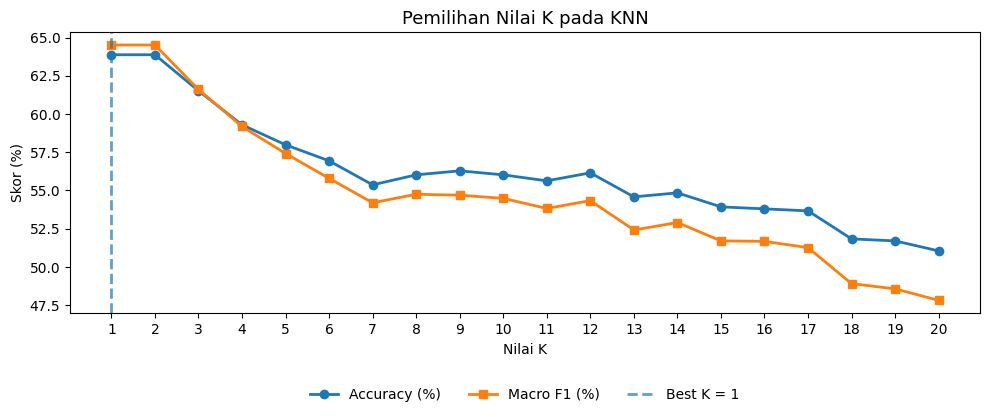

In [23]:
# Mencari Best K (Accuracy & Macro F1)
best_f1 = 0
best_k = 1
best_metric = None
best_weights = None

accuracies = []
f1_macros = []

print("\nMencari nilai K terbaik (Accuracy & Macro F1)...")

for k in range(1, 21):
    knn = KNeighborsClassifier(
        n_neighbors=k,
        weights='distance',
        metric='euclidean'
    )
    knn.fit(X_train_final, y_train)

    y_pred = knn.predict(X_val_final)

    acc = accuracy_score(y_val, y_pred)
    f1_macro = f1_score(y_val, y_pred, average='macro')

    accuracies.append(acc * 100)
    f1_macros.append(f1_macro * 100)

    print(f"K={k:2d} | Accuracy={acc*100:.2f}% | Macro F1={f1_macro*100:.2f}%")

    # Best berdasarkan Macro F1
    if f1_macro > best_f1:
        best_f1 = f1_macro
        best_k = k
        best_metric = knn.metric
        best_weights = knn.weights

print("\n===== BEST PARAMETER (BERDASARKAN MACRO F1) =====")
print(f"Best K        : {best_k}")
print(f"Metric        : {best_metric}")
print(f"Weights       : {best_weights}")
print(f"Macro F1      : {best_f1*100:.2f}%")

#===============================
# Visualisasi Accuracy & Macro F1
# ===============================
plt.figure(figsize=(10, 5))

ks = range(1, 21)

plt.plot(
    ks,
    accuracies,
    marker='o',
    linewidth=2,
    label='Accuracy (%)'
)

plt.plot(
    ks,
    f1_macros,
    marker='s',
    linewidth=2,
    label='Macro F1 (%)'
)

# ===============================
# TANDA K OPTIMAL
# ===============================
optimal_k = best_k  # = 19

# Garis vertikal
plt.axvline(
    x=optimal_k,
    linestyle='--',
    linewidth=2,
    alpha=0.7,
    label=f'Best K = {optimal_k}'
)

# ===============================
# Properti Plot
# ===============================
plt.title('Pemilihan Nilai K pada KNN', fontsize=13)
plt.xlabel('Nilai K')
plt.ylabel('Skor (%)')
plt.xticks(ks)

# Legend di bawah (konsisten VBNN)
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.22),
    ncol=3,
    frameon=False
)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

In [24]:
# Training
start_train = time.time()

knn_final = KNeighborsClassifier(
    n_neighbors=best_k,
    weights=best_weights,
    metric=best_metric
)
knn_final.fit(X_train_final, y_train)

train_time = time.time() - start_train
y_train_pred = knn_final.predict(X_train_final)

train_acc = accuracy_score(y_train, y_train_pred)
train_f1_macro = f1_score(y_train, y_train_pred, average='macro')

print("===== TRAINING PERFORMANCE =====")
print(f"Training Time: {train_time:.2f} detik")
print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Training Macro F1: {train_f1_macro * 100:.2f}%")

===== TRAINING PERFORMANCE =====
Training Time: 0.01 detik
Training Accuracy: 100.00%
Training Macro F1: 100.00%


## **EVALUATION**

In [25]:
start_pred = time.time()
y_pred = knn_final.predict(X_val_final)
pred_time = time.time() - start_pred


val_acc = accuracy_score(y_val, y_pred)
val_f1_macro = f1_score(y_val, y_pred, average='macro')

print("===== EVALUATION PERFORMANCE (VALIDATION SET) =====")
print(f"Accuracy        : {val_acc * 100:.2f}%")
print(f"Macro F1 Score  : {val_f1_macro * 100:.2f}%")
print(f"Waktu Prediksi  : {pred_time:.6f} detik")

===== EVALUATION PERFORMANCE (VALIDATION SET) =====
Accuracy        : 63.87%
Macro F1 Score  : 64.51%
Waktu Prediksi  : 0.016539 detik


Accuracy        : 63.87%
Macro F1 Score  : 64.51%
Waktu Prediksi  : 0.016539 detik

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.50      0.55       195
           1       0.55      0.39      0.46       120
           2       0.54      0.57      0.55        79
           3       0.73      0.80      0.76        84
           4       0.65      0.88      0.74        91
           5       0.70      0.83      0.76       120
           6       0.71      0.68      0.69        75

    accuracy                           0.64       764
   macro avg       0.64      0.66      0.65       764
weighted avg       0.63      0.64      0.63       764



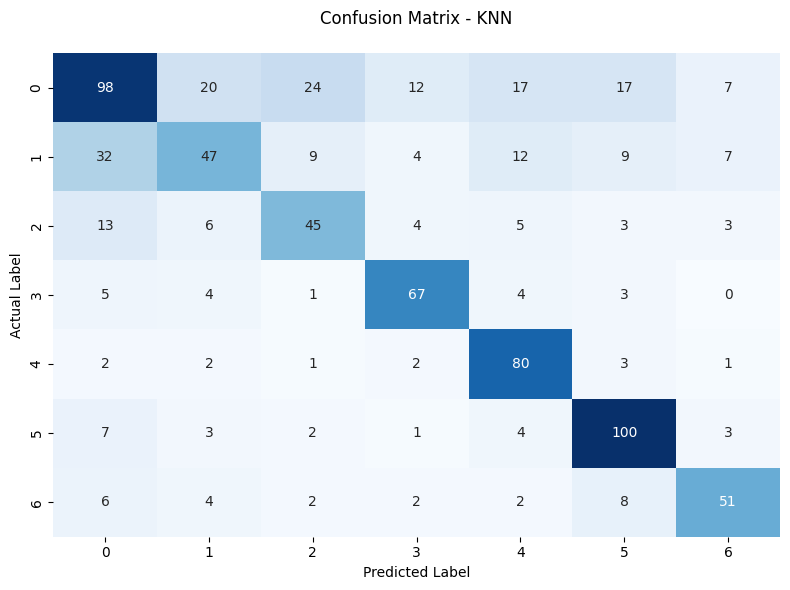

In [26]:
print(f"Accuracy        : {val_acc * 100:.2f}%")
print(f"Macro F1 Score  : {val_f1_macro * 100:.2f}%")
print(f"Waktu Prediksi  : {pred_time:.6f} detik")

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False
)

plt.title(
    f'Confusion Matrix - KNN\n',
    fontsize=12
)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.tight_layout()
plt.show()

In [27]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

f1_scores = []
acc_scores = []
pred_times = []

print("\n===== 5-FOLD CROSS VALIDATION =====")

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_final, y_train), 1):
    X_tr = X_train_final.values[train_idx]
    X_va = X_train_final.values[val_idx]
    y_tr = y_train.values[train_idx]
    y_va = y_train.values[val_idx]

    model_cv = KNeighborsClassifier(
        n_neighbors=best_k,
        weights=best_weights,
        metric=best_metric
    )
    model_cv.fit(X_tr, y_tr)

    start = time.time()
    y_pred_cv = model_cv.predict(X_va)
    pred_times.append(time.time() - start)

    acc_cv = accuracy_score(y_va, y_pred_cv)
    f1_cv = f1_score(y_va, y_pred_cv, average="macro")

    acc_scores.append(acc_cv)
    f1_scores.append(f1_cv)

    print(
        f"Fold {fold} | "
        f"Accuracy = {acc_cv*100:.2f}% | "
        f"Macro F1 = {f1_cv*100:.2f}%"
    )

print("\n===== CROSS-VALIDATION SUMMARY =====")
print(f"Accuracy Mean : {np.mean(acc_scores)*100:.2f}%")
print(f"Accuracy Std  : {np.std(acc_scores)*100:.2f}%")
print(f"Macro F1 Mean : {np.mean(f1_scores)*100:.2f}%")
print(f"Macro F1 Std  : {np.std(f1_scores)*100:.2f}%")
print(f"Avg Pred Time : {np.mean(pred_times):.4f} detik")


===== 5-FOLD CROSS VALIDATION =====
Fold 1 | Accuracy = 60.56% | Macro F1 = 59.36%
Fold 2 | Accuracy = 60.23% | Macro F1 = 59.87%
Fold 3 | Accuracy = 60.72% | Macro F1 = 59.98%
Fold 4 | Accuracy = 60.98% | Macro F1 = 60.19%
Fold 5 | Accuracy = 60.00% | Macro F1 = 59.02%

===== CROSS-VALIDATION SUMMARY =====
Accuracy Mean : 60.50%
Accuracy Std  : 0.35%
Macro F1 Mean : 59.68%
Macro F1 Std  : 0.43%
Avg Pred Time : 0.0127 detik


## **HYPERPARAMETER TUNNING**

In [28]:
print("\n" + "="*40)
print("MEMULAI PENCARIAN PARAMETER TERBAIK...")
print("="*40)

best_score = 0
best_k = 0
best_weight = ''
best_metric = ''

# K dari 1 sampai 30
# weight: uniform (sama rata) dan distance (yang dekat lebih berpengaruh)
# metric: euclidean, manhattan, minkowski
for k in range(1, 31):
    for weight in ['uniform', 'distance']:
        for metric in ['euclidean', 'manhattan', 'minkowski']:
            knn_tuning = KNeighborsClassifier(n_neighbors=k, weights=weight, metric=metric)
            knn_tuning.fit(X_train_final, y_train)
            score = knn_tuning.score(X_val_final, y_val)
            
            if score > best_score:
                best_score = score
                best_k = k
                best_weight = weight
                best_metric = metric

print(f"Parameter Terbaik Ditemukan:")
print(f"  - K (Jumlah Tetangga): {best_k}")
print(f"  - Weights (Bobot): {best_weight}")
print(f"  - Metric (Jarak): {best_metric}")
print(f"  - Akurasi Tertinggi: {best_score:.4f}")


MEMULAI PENCARIAN PARAMETER TERBAIK...
Parameter Terbaik Ditemukan:
  - K (Jumlah Tetangga): 1
  - Weights (Bobot): uniform
  - Metric (Jarak): manhattan
  - Akurasi Tertinggi: 0.6819



Classification Report (Model Optimal):
              precision    recall  f1-score   support

           0       0.70      0.54      0.61       195
           1       0.61      0.47      0.53       120
           2       0.60      0.63      0.62        79
           3       0.74      0.85      0.79        84
           4       0.67      0.91      0.77        91
           5       0.73      0.84      0.78       120
           6       0.70      0.73      0.71        75

    accuracy                           0.68       764
   macro avg       0.68      0.71      0.69       764
weighted avg       0.68      0.68      0.67       764



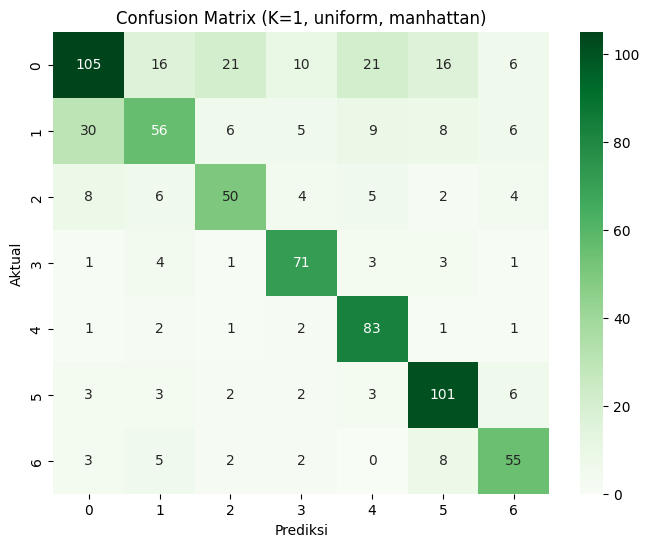

In [29]:
# evaluasi model dengan parameter terbaik
final_model = KNeighborsClassifier(n_neighbors=best_k, weights=best_weight, metric=best_metric)
final_model.fit(X_train_final, y_train)
final_pred = final_model.predict(X_val_final)

print("\nClassification Report (Model Optimal):")
print(classification_report(y_val, final_pred))

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_val, final_pred), annot=True, fmt='d', cmap='Greens')
plt.title(f'Confusion Matrix (K={best_k}, {best_weight}, {best_metric})')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()